In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 2.7 MB/s 
     |████████████████████████████████| 376 kB 12.9 MB/s 
     |████████████████████████████████| 58 kB 2.3 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=e9381e45813dcaa621e582969d356bee0980f99514e8a9ba2a26c582bde1d05a
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=db247b5efb9c2d2925e1dcc9b5dccd2f0f30cfc060ea1c582be194418360bad2
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 15.74 MiB/s, done.


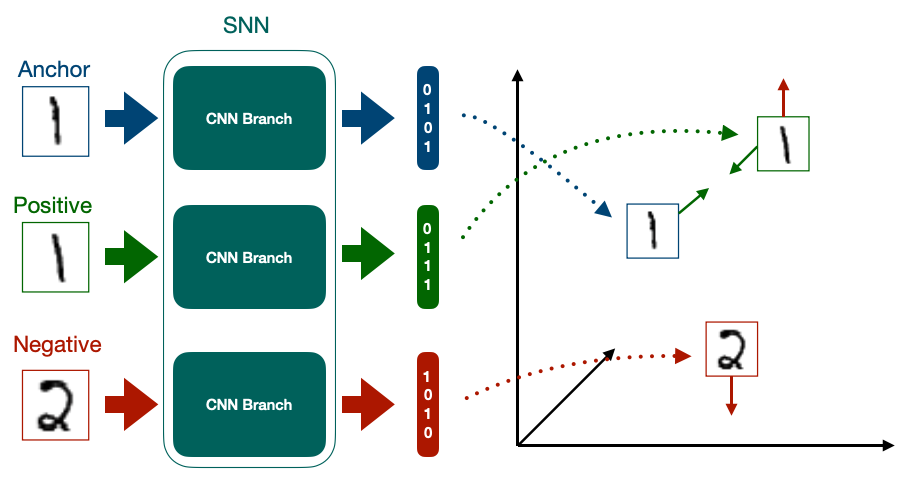

# Imports

In [3]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

# Configurations

In [5]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [7]:
row = df.iloc[13]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

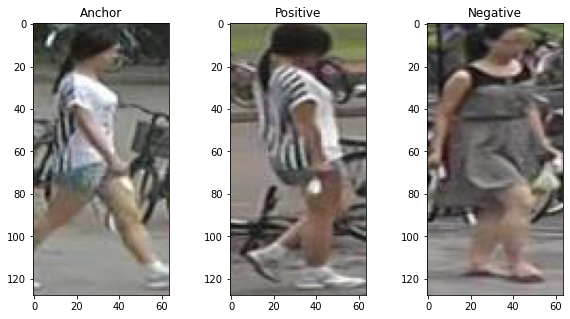

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
print(train_df.shape, valid_df.shape)

(3200, 3) (800, 3)


# Create APN Dataset 

In [11]:
class APN_Dataset(Dataset):
  def __init__(self, df) -> None:
      self.df = df
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
      row = self.df.iloc[index]

      A_img = io.imread(DATA_DIR + row.Anchor)
      P_img = io.imread(DATA_DIR + row.Positive)
      N_img = io.imread(DATA_DIR + row.Negative)

      A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0  # permute: (h, w, c)->(c, h, w)
      P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
      N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

      return A_img, P_img, N_img

In [12]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f'Size of trainset: {len(trainset)}')
print(f'Size of validset: {len(validset)}')

Size of trainset: 3200
Size of validset: 800


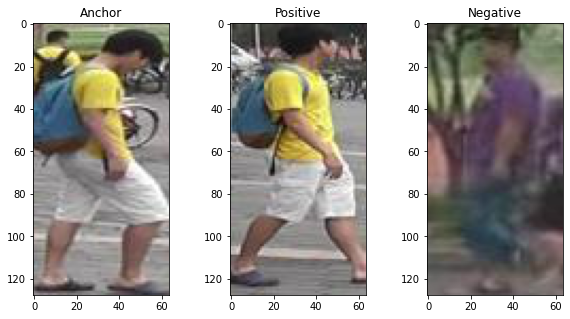

In [13]:
idx = 1
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [14]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [15]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [16]:
for A, P, N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model 

In [17]:
class APN_Model(nn.Module):
  def __init__(self, emb_size=512) -> None:
      super(APN_Model, self).__init__()

      self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
      self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [18]:
model = APN_Model()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine

# Create Train and Eval function

In [19]:
def train_fn(model: APN_Model, dataloader: DataLoader, optimizer, criterion):
  model.train()
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [20]:
def valid_fn(model: APN_Model, dataloader: DataLoader, criterion):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [21]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Create Training Loop

In [22]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = valid_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print('SAVED_WEIGHTS success')
  
  print(f'EPOCH: {i+1} \t trainloss: {train_loss} \t validloss: {valid_loss}')

100%|██████████| 25/25 [00:02<00:00, 11.17it/s]


SAVED_WEIGHTS success
EPOCH: 1 	 trainloss: 0.6594287385046482 	 validloss: 0.7990078282356262


100%|██████████| 25/25 [00:02<00:00, 11.19it/s]


SAVED_WEIGHTS success
EPOCH: 2 	 trainloss: 0.356591487377882 	 validloss: 0.3800527667999268


100%|██████████| 25/25 [00:02<00:00, 11.07it/s]


SAVED_WEIGHTS success
EPOCH: 3 	 trainloss: 0.18122286185622216 	 validloss: 0.27508309185504914


100%|██████████| 25/25 [00:02<00:00, 11.04it/s]


SAVED_WEIGHTS success
EPOCH: 4 	 trainloss: 0.14084239646792412 	 validloss: 0.1521136873960495


100%|██████████| 25/25 [00:02<00:00, 11.08it/s]


EPOCH: 5 	 trainloss: 0.0944613290578127 	 validloss: 0.20343404352664948


100%|██████████| 25/25 [00:02<00:00, 11.06it/s]


EPOCH: 6 	 trainloss: 0.09913060471415519 	 validloss: 0.2613731098175049


100%|██████████| 25/25 [00:02<00:00, 11.06it/s]


SAVED_WEIGHTS success
EPOCH: 7 	 trainloss: 0.08377883523702621 	 validloss: 0.12639335334300994


100%|██████████| 25/25 [00:02<00:00, 10.96it/s]


EPOCH: 8 	 trainloss: 0.05791745588183403 	 validloss: 0.20546626567840576


100%|██████████| 25/25 [00:02<00:00, 11.07it/s]


EPOCH: 9 	 trainloss: 0.04387352764606476 	 validloss: 0.19397386252880097


100%|██████████| 25/25 [00:02<00:00, 11.21it/s]


EPOCH: 10 	 trainloss: 0.026821160316467287 	 validloss: 0.15821188807487488


100%|██████████| 25/25 [00:02<00:00,  8.66it/s]


EPOCH: 11 	 trainloss: 0.04050172597169876 	 validloss: 0.14154269874095918


100%|██████████| 25/25 [00:02<00:00, 10.96it/s]


EPOCH: 12 	 trainloss: 0.02832027181982994 	 validloss: 0.13473646491765975


100%|██████████| 25/25 [00:02<00:00, 10.90it/s]


EPOCH: 13 	 trainloss: 0.03673993110656738 	 validloss: 0.2011263370513916


100%|██████████| 25/25 [00:02<00:00, 11.03it/s]


EPOCH: 14 	 trainloss: 0.05283849120140076 	 validloss: 0.23713925004005432


100%|██████████| 25/25 [00:02<00:00, 10.87it/s]

EPOCH: 15 	 trainloss: 0.05301481708884239 	 validloss: 0.15741855055093765


# Get Anchor Embeddings

In [23]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0)) # add batch -> (batch, c, h, w)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis=1)
    
  return df_enc

In [24]:
model.load_state_dict(torch.load('/content/best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:42<00:00, 94.68it/s]


In [25]:
df_enc.to_csv('/content/database.csv', index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.207341,0.567654,0.273381,0.785706,0.850548,0.169371,-0.772648,-0.009511,0.629642,...,-0.591963,0.280470,-0.203088,0.455246,-0.340349,-0.061348,0.505868,0.516158,-0.068101,-0.931861
1,1420_c3s3_061978_03.jpg,0.591831,0.540493,-0.167494,0.743136,0.720496,0.166031,-0.809314,-0.095236,0.784788,...,-0.298012,0.229307,-0.070605,-0.022206,-0.137528,0.050465,0.444179,0.262684,0.118272,-0.789773
2,1420_c5s3_062565_05.jpg,0.289944,0.126994,0.336921,0.359353,0.733283,0.038322,-0.410939,0.317588,1.052622,...,-0.119830,0.390036,-0.232006,0.318719,-0.648958,0.200630,0.079037,-0.045378,0.114209,-0.945539
3,1420_c6s3_085592_04.jpg,0.584145,0.057220,-0.029636,0.577534,0.697555,0.318864,-0.320337,0.146807,1.064576,...,-0.226577,0.375743,-0.353370,0.331112,-0.537699,0.157913,0.167669,0.007842,-0.115355,-1.113322
4,0663_c5s3_085987_03.jpg,-1.156364,0.192363,1.132089,0.529217,-0.382088,-0.175905,-0.005292,-0.088576,-1.230023,...,-0.464003,-0.209450,0.639124,0.521946,0.873326,-0.017264,0.571638,0.534071,-0.828574,0.239486


# Inference

In [26]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc-anc_enc_arr).T))
  return dist

In [27]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [28]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [29]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1 :])
  distance = np.append(distance, dist)

In [30]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.7/dist-packages/networkx/drawing/layout.py:727: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


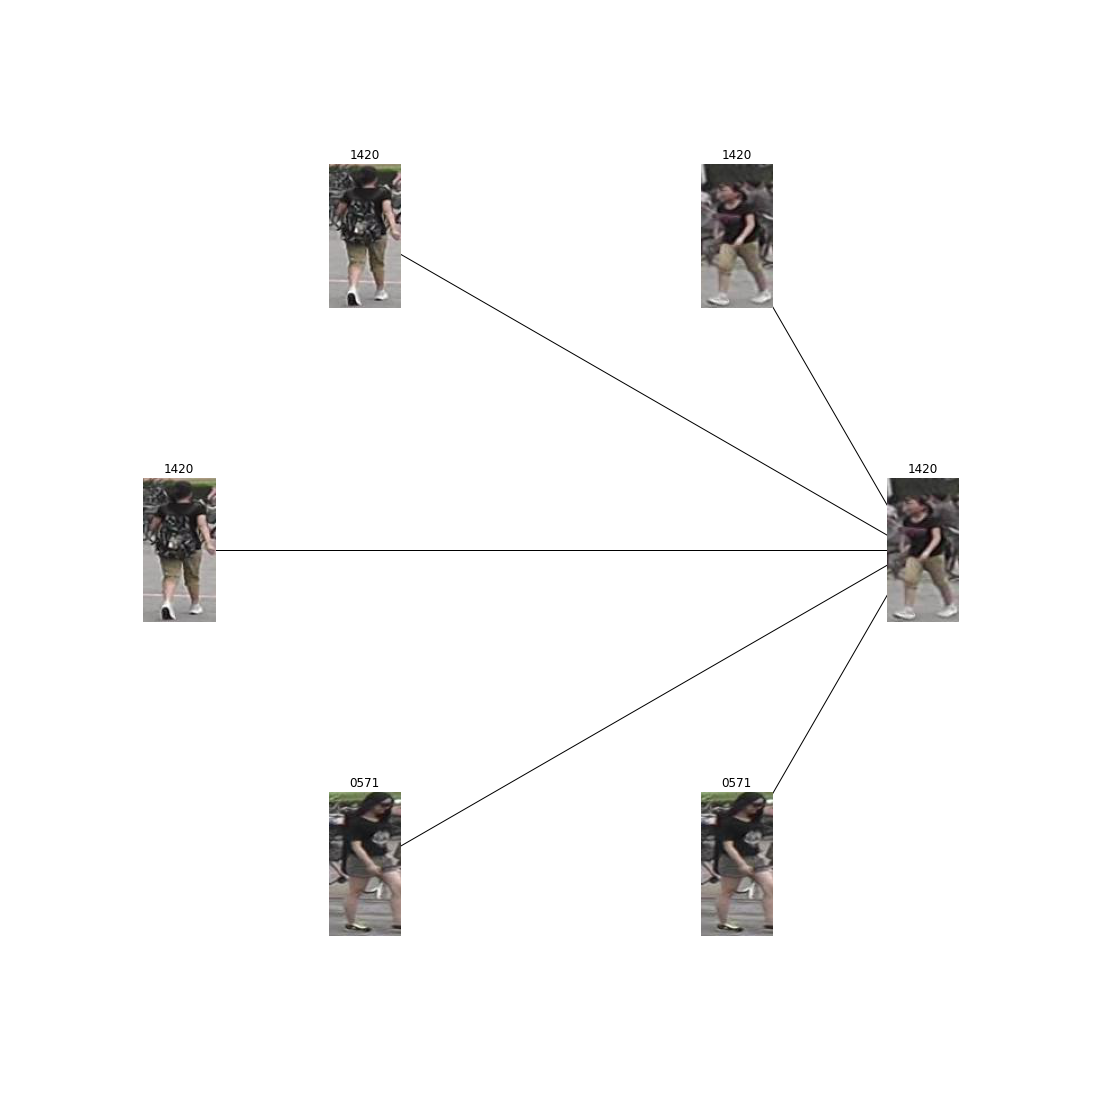

In [31]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);